# Importações iniciais

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications import VGG16

In [2]:
data_folder = '/kaggle/input/arquivos-card-20/Material/fer2013/fer2013/fer2013.csv'
data = pd.read_csv(data_folder)
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Visualizando os dados

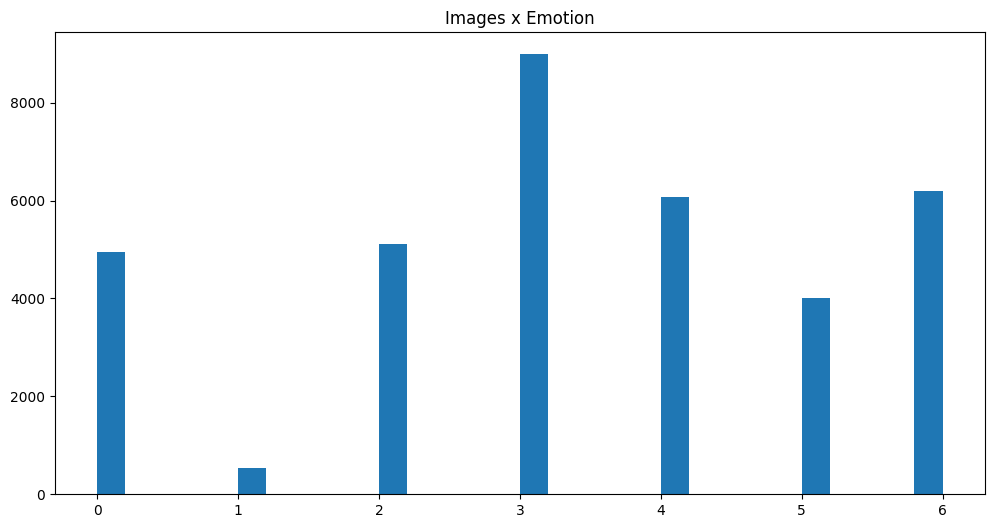

In [3]:
plt.figure(figsize=(12,6))
plt.hist(data['emotion'], bins=30)
plt.title('Images x Emotion')
plt.show()

# Classes: ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Pré-processamento

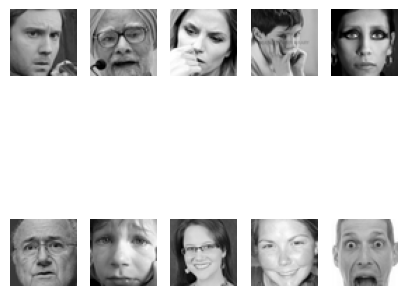

In [4]:
pixels = data['pixels'].tolist() # converte a Series para lista
height, width = 48,48

fig, axs = plt.subplots(2,5,figsize=(5,5))
faces = []
samples = 0
for pixel_sequence in pixels: # itera por cada imagem
    face = [int(pixel) for pixel in pixel_sequence.split(' ')] # converte os pixels de string para inteiro
    face = np.asarray(face).reshape(width, height, 1) # adiciona dimensão de cor
    # as imagens estão em grayscale, mas a VGG16 aceita imagens RGB
    # conversão de grayscale para RGB através de stacking (se um valor grayscale é X, em RGB será (X,X,X))
    face = np.asarray(np.dstack((face, face, face)), dtype=np.uint8)
    
    faces.append(face)
    
    if (samples < 10): # imprime as 10 primeiras faces para monitoramento
        axs.flat[samples].imshow(face)
        axs.flat[samples].axis('off')
    samples += 1

faces = np.asarray(faces).astype('float32') / 255. # converte para float e normaliza

emotions = pd.get_dummies(data['emotion']).to_numpy() # pega os códigos one-hot das emoções para cada imagem

# Divisão dos conjuntos de treino e teste

In [5]:
X_train, X_test, y_train, y_test = train_test_split(faces, emotions, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=41)

print(f'Number of images in the training ds: {len(X_train)}')
print(f'Number of images in the testing ds: {len(X_test)}')
print(f'Number of images in the validation ds: {len(X_val)}')

Number of images in the training ds: 29068
Number of images in the testing ds: 3589
Number of images in the validation ds: 3230


In [6]:
np.save('mod_xtest', X_test) # salva o conjunto previsor de teste
np.save('mod_ytest', y_test) # salva o conjunto de classes de teste

# Arquitetura do modelo

Será feito transfer learning com a estrutura da VGG16, treinada com mais de 14 milhões de amostras divididas entre 1000 classes (base ImageNet).<br>
Como se trata de um conjunto de dados diferente, com um número de classes diferente, não será incluso a parte da Rede Neural Densa (top) original.<br>
Será assumido também que as imagens do conjunto fer2013 são semelhantes a da ImageNet, portanto, os pesos das camadas convolucionais serão congelados, sendo treinados apenas os pesos da nova Rede Densa.<br>

In [7]:
num_classes = 7
batch_size = 16
epochs = 30

# importando a VGG16:
vgg = VGG16(input_shape=(width, height, 3), # inputs de (48, 48, 3)
            weights='imagenet', # importa a VGG16 com os pesos obtidos com o treino com o ds ImageNet
            include_top=False) # exclui a Rede Densa original

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
vgg.trainable = False # congela os pesos das camadas importadas (convolucionais) da vgg
global_average_layer = GlobalAveragePooling2D() # planifica o último output das camadas convolucionais através de Global Avg Pooling
prediction_layer = Dense(num_classes, activation = 'softmax') # cria uma camada de saída específica para esse problema (7 classes)

In [9]:
import tensorflow.keras.backend as k
k.clear_session()
# criando a estrutura final do modelo:
model = Sequential([
    vgg,
    global_average_layer,
    prediction_layer
])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
# compilando o modelo:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])
arquivo_modelo = "modelo_vgg_expressoes.weights.h5" # arquivo do modelo
arquivo_modelo_json = "modelo_vgg_expressoes.json" # arquivo do json, para salvar a arquitetura

# definindo callbacks:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

In [12]:
# salvando a estrutura do modelo em json:
model_json = model.to_json()
with open(arquivo_modelo_json, "w") as json_file:
    json_file.write(model_json)

In [14]:
history = model.fit(np.array(X_train), np.array(y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(np.array(X_val), np.array(y_val)),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/30


I0000 00:00:1730292404.115576      98 service.cc:145] XLA service 0x799e980060d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730292404.115638      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  30/1817 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.1548 - loss: 2.1150 

I0000 00:00:1730292406.348055      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1817/1817 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3148 - loss: 1.7143
Epoch 1: val_loss improved from inf to 1.56568, saving model to modelo_vgg_expressoes.weights.h5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3148 - loss: 1.7143 - val_accuracy: 0.3988 - val_loss: 1.5657 - learning_rate: 0.0010
Epoch 2/30
1811/1817 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3945 - loss: 1.5690
Epoch 2: val_loss improved from 1.56568 to 1.53380, saving model to modelo_vgg_expressoes.weights.h5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3945 - loss: 1.5689 - val_accuracy: 0.4062 - val_loss: 1.5338 - learning_rate: 0.0010
Epoch 3/30
1814/1817 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4047 - loss: 1.5370
Epoch 3: val_loss improved from 1.53380 to 1.52662, saving model to modelo_vgg_expressoes.weights.h5
1817/1817 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.4047 - loss: 1.5370 - val_accuracy: 0.4158 - val_loss: 1.5266 - learning_rate: 0.0010
Epoch 4/30
1815/

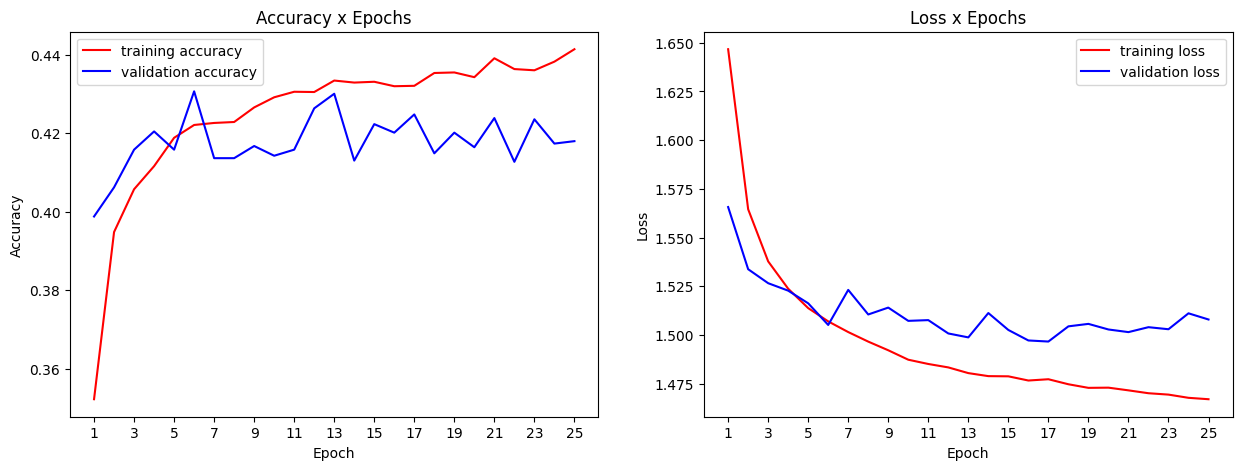

In [15]:
def plot_model_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axs[0].plot(range(1, len(history.history['accuracy']) + 1),
                history.history['accuracy'], 'r')
    axs[0].plot(range(1, len(history.history['val_accuracy']) + 1),
                history.history['val_accuracy'], 'b')
    axs[0].set_title('Accuracy x Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(history.history['accuracy']) + 1, max(1, len(history.history['accuracy']) // 10)))
    axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

    # Plot loss
    axs[1].plot(range(1, len(history.history['loss']) + 1),
                history.history['loss'], 'r')
    axs[1].plot(range(1, len(history.history['val_loss']) + 1),
                history.history['val_loss'], 'b')
    axs[1].set_title('Loss x Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(history.history['loss']) + 1, max(1, len(history.history['loss']) // 10)))
    axs[1].legend(['training loss', 'validation loss'], loc='best')
    
    fig.savefig('model_history_mod01.png')
    plt.show()
    
plot_model_history(history)

O desempenho do modelo não ficou muito bom, piorando bastante em relação a CNN feita do zero.<br>
Isso provavelmente se deve ao fato de termos utilizado a extração de features (camadas convolucionais) da VGG16, assumindo que o conjunto da fer2013 é parecido com o do ImageNet, o que provavelmente não é bem verdade.